# Tiny ImageNet - Resnet-18

In [1]:
!pip install -U albumentations
!pip install gitpython

     |████████████████████████████████| 102 kB 5.4 MB/s 
     |████████████████████████████████| 47.6 MB 2.4 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 180 kB 5.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


In [2]:
import git
import os
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
os.chdir("/content/")

In [4]:
if os.path.isdir("/content/Transformer-DeepLearning"):
  !rm -rf "/content/Transformer-DeepLearning"

In [5]:
!git clone https://github.com/amitkml/Transformer-DeepLearning 

Cloning into 'Transformer-DeepLearning'...
remote: Enumerating objects: 1015, done.
remote: Counting objects: 100% (1015/1015), done.
remote: Compressing objects: 100% (721/721), done.
remote: Total 1015 (delta 609), reused 636 (delta 278), pack-reused 0
Receiving objects: 100% (1015/1015), 25.75 MiB | 26.58 MiB/s, done.
Resolving deltas: 100% (609/609), done.


In [6]:
os.chdir("/content/Transformer-DeepLearning/ConvModelAdvancedTraining")
# import resnet as resnet
# import resnet_ln as resnet_ln
import data_engine as data_engine
import data_transforms as data_transforms
import prepare_tiny_imagenet_200 as  prepare_tiny_imagenet_200

In [7]:
os.chdir("/content/Transformer-DeepLearning/ConvModelAdvancedTraining/models")
# import resnet as resnet
# import resnet_ln as resnet_ln
import resnet_tiny_imagenet as resnet_tiny_imagenet

In [8]:
!pip install torchsummary
from torchsummary import summary

In [9]:
os.chdir("/content/Transformer-DeepLearning/ConvModelAdvancedTraining")
# %tb
import utils as utils
import main as model_main
import lr_finder as lr_finder
# import prepare_tiny_imagenet_200 as prepare_tiny_imagenet_200
import config as config
# import data_engine as dataEngine
from results import plot_images, plot_graph
# import gradcam.final_gradcam as final_gradcam

In [10]:
os.chdir("/content/Transformer-DeepLearning/ConvModelAdvancedTraining/gradcam/")
import visualize as  VisualizeCam
import final_gradcam as show_final_gradcam

In [11]:
os.chdir("/content")

### Download TinyImageNet

If done correctly, you should see the folders appear on the Colab sidebar:

![im](https://miro.medium.com/max/700/1*ckWn4JtTd6kGw5k5d44tLQ.png)

In [12]:
prepare_tiny_imagenet_200.download_dataset()
prepare_tiny_imagenet_200.unzip_data()

Beginning dataset download with urllib2
Dataset downloaded
Extracting zip file: /content/tiny-imagenet-200.zip
Extracted at: /content


**Organize validation data folder**

You will notice that the training folder meets the structure needed for ImageLoader but the validation folder does not.

The images in the validation folder are all saved within a single folder, so we need to reorganize them into sub-folders based on their labels.

The validation folder contains a val_annotations.txt file which comprises six tab-separated columns: filename, class label, and details of the bounding box (x,y coordinates, height, width).

![im](https://miro.medium.com/max/700/1*OhbJEgbizRCU0Em0X03eeA.png)

In [13]:
# prepare_tiny_imagenet_200.split_train_test()
prepare_tiny_imagenet_200.format_val()

Formatting: /content/tiny-imagenet-200/val
Cleaning up: /content/tiny-imagenet-200/val/images
Formatting val done


### Model Configuration and Set Seed

In [14]:
# View model config
model_config_data = config.ModelConfig()
model_config_data.print_config()
# print()
# Set seed
utils.init_seed(model_config_data)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 256,
  'dropout': 0,
  'epochs': 15,
  'final_test_data_path': '/content/tiny-imagenet-200/new_val',
  'l1_decay': 0,
  'l2_decay': 0.005,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1,
  'test_data_path': '/content/tiny-imagenet-200/val',
  'train_data_path': '/content/tiny-imagenet-200/train'}
CUDA Available


### Data Loading and Visualization

In [15]:
# from data.data_transforms import albumentations_transforms, torch_transforms
# from utils import has_cuda, imshow, unnormalize
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import torch
import torchvision

# class TinyDataEngine(object):

# 	classes = ["%s" % i for i in range(200)]

# 	def __init__(self, args):
# 		super(TinyDataEngine, self).__init__()
# 		self.batch_size_cuda = args.batch_size_cuda
# 		self.batch_size_cpu = args.batch_size_cpu
# 		self.num_workers = args.num_workers
# 		self.train_data_path = args.train_data_path
# 		self.test_data_path = args.test_data_path
# 		self.load()

# 	def _transforms(self):
# 		# Data Transformations
# 		train_transform = albumentations_transforms(p=1.0, is_train=True)
# 		test_transform = albumentations_transforms(p=1.0, is_train=False)
# 		return train_transform, test_transform

# 	def _dataset(self):
# 		# Get data transforms
# 		train_transform, test_transform = self._transforms()

# 		# Dataset and Creating Train/Test Split
# 		train_set = torchvision.datasets.ImageFolder(root=self.train_data_path,
# 			transform=train_transform)
# 		test_set = torchvision.datasets.ImageFolder(root=self.test_data_path,
# 			transform=test_transform)
# 		return train_set, test_set

# 	def load(self):
# 		# Get Train and Test Data
# 		train_set, test_set = self._dataset()

# 		# Dataloader Arguments & Test/Train Dataloaders
# 		dataloader_args = dict(
# 			shuffle= True,
# 			batch_size= self.batch_size_cpu)
# 		if has_cuda():
# 			dataloader_args.update(
# 				batch_size= self.batch_size_cuda,
# 				num_workers= self.num_workers,
# 				pin_memory= True)

# 		self.train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)
# 		self.test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

# 	def show_samples(self):
# 		# get some random training images
# 		dataiter = iter(self.train_loader)
# 		images, labels = dataiter.next()
# 		index = []
# 		num_img = min(len(self.classes), 10)
# 		for i in range(num_img):
# 			for j in range(len(labels)):
# 				if labels[j] == i:
# 					index.append(j)
# 					break
# 		if len(index) < num_img:
# 			for j in range(len(labels)):
# 				if len(index) == num_img:
# 					break
# 				if j not in index:
# 					index.append(j)
# 		imshow_detais(torchvision.utils.make_grid(images[index],
# 				nrow=num_img, scale_each=True), "Sample train data")

In [16]:
# def imshow_detais(img, title, numpy_conversion=True):
# 	img = unnormalize(img)
# 	npimg = img.numpy()
# 	fig = plt.figure(figsize=(15,7))
# 	plt.imshow(np.transpose(img, (1, 2, 0)))
# 	plt.title(title)

In [17]:
data = data_engine.DataEngine(model_config_data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
# dataiter = iter(data.train_loader)
# images, labels = dataiter.next()

In [19]:
# type(img)

In [20]:
# # images[0]
# img = unnormalize(images[0])
# plt.imshow(np.transpose(img, (1, 2, 0)))
# plt.title(title)

In [21]:
# data = data_engine.DataEngine(model_config_data)
# data.show_samples()

### LR finder

In [22]:
%tb
# max_lr = lr_finder.lr_finder_ls()

No traceback available to show.


In [23]:
# start_lr = 1e-3
# print(f"Max LR forund from LR Finder:{start_lr}")
# max_lr = max_lr[-1]/10


In [24]:
start_lr = 1e-3
# max_lr = 0.0172685370741483 (Working with 87%)
max_lr = 0.272685370741483  # 0.009746555323590814

### Visualize Network Architecture


In [25]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [26]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [27]:
# my_model = model_main.get_model(type = "resnet18")
device = utils.which_device()
model = resnet_tiny_imagenet.TinyImageNetResNet18(num_classes=200).to(device)
utils.show_model_summary(model, (3,64,64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [28]:
!pip install hiddenlayer

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:1630: UserWarning: Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "


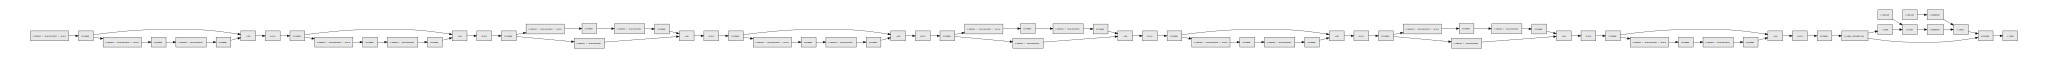

In [29]:
import hiddenlayer as hl
input = torch.zeros([1, 3, 64, 64])
hl.build_graph(model, input.to(device))

## Final Model - Training

In [30]:
# start_lr = 0.015
# # max_lr = 0.0172685370741483 
# max_lr = 0.018272685370741483
# start_lr = max_lr/5

In [31]:
# import torch
# from tqdm import tqdm

# def train(model, device, train_loader, criterion, optimizer, epoch,
#           l1_decay, l2_decay, train_losses, train_accs, scheduler=None):
#   model.train()
#   pbar = tqdm(train_loader)
#   correct = 0
#   processed = 0
#   avg_loss = 0
#   for batch_idx, (data, target) in enumerate(pbar):
#     # get samples
#     data, target = data.to(device), target.to(device)

#     # Init
#     optimizer.zero_grad()
#     # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
#     # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

#     # Predict
#     y_pred = model(data)

#     # Calculate loss
#     loss = criterion(y_pred, target)
#     if l1_decay > 0:
#       l1_loss = 0
#       for param in model.parameters():
#         l1_loss += torch.norm(param,1)
#       loss += l1_decay * l1_loss
#     if l2_decay > 0:
#       l2_loss = 0
#       for param in model.parameters():
#         l2_loss += torch.norm(param,2)
#       loss += l2_decay * l2_loss

#     # Backpropagation
#     loss.backward()
#     optimizer.step()
#     if scheduler:
#       scheduler.step()

#     # Update pbar-tqdm
#     pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#     correct += pred.eq(target.view_as(pred)).sum().item()
#     processed += len(data)
#     avg_loss += loss.item()

#     pbar_str = f'Loss={loss.item():0.5f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
#     if l1_decay > 0:
#       pbar_str = f'L1_loss={l1_loss.item():0.3f} %s' % (pbar_str)
#     if l2_decay > 0:
#       pbar_str = f'L2_loss={l2_loss.item():0.3f} %s' % (pbar_str)

#     pbar.set_description(desc= pbar_str)

#   avg_loss /= len(train_loader)
#   avg_acc = 100*correct/processed
#   train_accs.append(avg_acc)
#   train_losses.append(avg_loss)

In [32]:
# import torch

# def test(model, device, test_loader, criterion, classes, test_losses, test_accs,
#          misclassified_imgs, correct_imgs, is_last_epoch):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss +=criterion(output, target).item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             is_correct = pred.eq(target.view_as(pred))
#             if is_last_epoch:
#               misclassified_inds = (is_correct==0).nonzero()[:,0]
#               for mis_ind in misclassified_inds:
#                 if len(misclassified_imgs) == 25:
#                   break
#                 misclassified_imgs.append({
#                     "target": target[mis_ind].cpu().numpy(),
#                     "pred": pred[mis_ind][0].cpu().numpy(),
#                     "img": data[mis_ind]
#                 })
              
#               correct_inds = (is_correct==1).nonzero()[:,0]
#               for ind in correct_inds:
#                 if len(correct_imgs) == 25:
#                   break
#                 correct_imgs.append({
#                     "target": target[ind].cpu().numpy(),
#                     "pred": pred[ind][0].cpu().numpy(),
#                     "img": data[ind]
#                 })
#             correct += is_correct.sum().item()

#     test_loss /= len(test_loader)
#     test_losses.append(test_loss)
    
#     test_acc = 100. * correct / len(test_loader.dataset)
#     test_accs.append(test_acc)

#     if test_acc >= 90.0:
#         classwise_acc(model, device, test_loader, classes)

#     print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset), test_acc))

# def classwise_acc(model, device, test_loader, classes):
#     class_correct = list(0. for i in range(10))
#     class_total = list(0. for i in range(10))
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             c = (predicted == labels).squeeze()
#             for i in range(4):
#                 label = labels[i]
#                 class_correct[label] += c[i].item()
#                 class_total[label] += 1
    
#     # print class-wise test accuracies
#     print()
#     for i in range(10):
#       print('Accuracy of %5s : %2d %%' % (
#           classes[i], 100 * class_correct[i] / class_total[i]))
#     print()

In [33]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR,OneCycleLR
import torch.optim as optim

In [34]:
# def train_model(model,
#                 data,
#                 device,
#                 model_config_data,
#                 criterion = nn.CrossEntropyLoss(),
#                 lr = 0.01,
#                 max_lr = 0.02,
#                 epochs = 30
#                 ):
#   l1_decay = model_config_data.l1_decay
#   l2_decay = model_config_data.l2_decay
#   criterion = criterion
#   optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=model_config_data.momentum)
#   scheduler = OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(data.train_loader),
#                        epochs=epochs, div_factor=10, final_div_factor=10,
#                        pct_start=10/epochs)
#   test_losses, train_losses, test_accs, train_accs = [], [], [], []
#   misclassified_imgs, correct_imgs = [], []
#   lr_trend = []
#   for epoch in range(epochs):
#     lr_trend.append(optimizer.param_groups[0]['lr'])
#     print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
#     train(model, device, data.train_loader, criterion, optimizer, epoch,
#             l1_decay,l2_decay, train_losses, train_accs, scheduler)
#     test(model, device, data.test_loader, criterion, data.classes, test_losses,
#            test_accs, misclassified_imgs, correct_imgs, False)

In [35]:
def train_model_validate(model,
                data,
                device,
                model_config_data,
                lr = 0.01,
                max_lr = 0.02,
                epochs = 30,
                criterion = nn.CrossEntropyLoss()
                ):
  
  l1_decay = model_config_data.l1_decay
  l2_decay = model_config_data.l2_decay
  criterion = criterion
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=model_config_data.momentum)
  scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(data.train_loader),
                       epochs=epochs, div_factor=10, final_div_factor=10,
                       pct_start=10/epochs)
  test_losses, train_losses, test_accs, train_accs = [], [], [], []
  misclassified_imgs, correct_imgs = [], []
  lr_trend = []  
  for epoch in range(epochs):
          lr_trend.append(optimizer.param_groups[0]['lr'])
          print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
          train_model(model, device, data.train_loader, criterion, optimizer, epoch,l1_decay,l2_decay, train_losses, train_accs, scheduler)
          test_model(model, epoch, device, data.test_loader, criterion, data.classes, test_losses, test_accs, misclassified_imgs, correct_imgs, False)
                          
  return test_losses, train_losses, test_accs, train_accs, misclassified_imgs, correct_imgs, lr_trend

In [ ]:
test_losses, train_losses, test_accs, train_accs, misclassified_imgs, correct_imgs, lr_trend = model_main.train_model_validate(model = model,
                                                                                                                               data = data,
                                                                                                                               device = device,
                                                                                                                               model_config_data = model_config_data,
                                                                                                                               lr = 0.1,
                                                                                                                               max_lr = 0.02,
                                                                                                                               epochs = 30,
                                                                                                                               criterion=nn.CrossEntropyLoss())

EPOCH: 1 (LR: 0.002000)


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
L2_loss=462.929 Loss=6.41543 Batch_id=390 Accuracy=6.18: 100%|██████████| 391/391 [15:36<00:00,  2.39s/it]


Saving..
Test set: Average loss: 4.1612, Accuracy: 1108/10000 (11.08%)

EPOCH: 2 (LR: 0.002441)


L2_loss=460.465 Loss=5.81366 Batch_id=390 Accuracy=15.27: 100%|██████████| 391/391 [15:36<00:00,  2.40s/it]


Saving..
Test set: Average loss: 3.6775, Accuracy: 1829/10000 (18.29%)

EPOCH: 3 (LR: 0.003720)


L2_loss=457.614 Loss=5.63500 Batch_id=390 Accuracy=22.20: 100%|██████████| 391/391 [15:36<00:00,  2.40s/it]


Saving..
Test set: Average loss: 3.4026, Accuracy: 2232/10000 (22.32%)

EPOCH: 4 (LR: 0.005712)


L2_loss=454.443 Loss=5.28439 Batch_id=390 Accuracy=27.68: 100%|██████████| 391/391 [15:37<00:00,  2.40s/it]


Saving..
Test set: Average loss: 3.2784, Accuracy: 2538/10000 (25.38%)

EPOCH: 5 (LR: 0.008222)


L2_loss=450.908 Loss=4.99314 Batch_id=390 Accuracy=32.90: 100%|██████████| 391/391 [15:33<00:00,  2.39s/it]


Saving..
Test set: Average loss: 3.0239, Accuracy: 2979/10000 (29.79%)

EPOCH: 6 (LR: 0.011004)


L2_loss=447.033 Loss=4.56506 Batch_id=390 Accuracy=36.79: 100%|██████████| 391/391 [15:33<00:00,  2.39s/it]


Saving..
Test set: Average loss: 2.7988, Accuracy: 3387/10000 (33.87%)

EPOCH: 7 (LR: 0.013785)


L2_loss=442.875 Loss=4.70448 Batch_id=390 Accuracy=40.16: 100%|██████████| 391/391 [15:33<00:00,  2.39s/it]


Test set: Average loss: 2.9356, Accuracy: 3217/10000 (32.17%)

EPOCH: 8 (LR: 0.016294)


L2_loss=438.546 Loss=4.24444 Batch_id=390 Accuracy=43.31: 100%|██████████| 391/391 [15:33<00:00,  2.39s/it]


Test set: Average loss: 3.0994, Accuracy: 3086/10000 (30.86%)

EPOCH: 9 (LR: 0.018285)


L2_loss=434.101 Loss=4.40979 Batch_id=390 Accuracy=46.20: 100%|██████████| 391/391 [15:35<00:00,  2.39s/it]


Saving..
Test set: Average loss: 2.6355, Accuracy: 3875/10000 (38.75%)

EPOCH: 10 (LR: 0.019562)


L2_loss=429.582 Loss=4.58842 Batch_id=390 Accuracy=48.48: 100%|██████████| 391/391 [15:34<00:00,  2.39s/it]


Saving..
Test set: Average loss: 2.4197, Accuracy: 4236/10000 (42.36%)

EPOCH: 11 (LR: 0.020000)


L2_loss=425.015 Loss=3.96372 Batch_id=390 Accuracy=50.69: 100%|██████████| 391/391 [15:33<00:00,  2.39s/it]


Saving..
Test set: Average loss: 2.3959, Accuracy: 4292/10000 (42.92%)

EPOCH: 12 (LR: 0.019877)


L2_loss=420.525 Loss=4.21451 Batch_id=390 Accuracy=52.86: 100%|██████████| 391/391 [15:34<00:00,  2.39s/it]


Saving..
Test set: Average loss: 2.3542, Accuracy: 4327/10000 (43.27%)

EPOCH: 13 (LR: 0.019514)


L2_loss=417.633 Loss=3.84777 Batch_id=258 Accuracy=54.85:  66%|██████▌   | 258/391 [10:19<05:16,  2.38s/it]

In [ ]:
# test_losses, train_losses, test_accs, train_accs, misclassified_imgs, correct_imgs, lr_trend = model_main.train_model(model,
#                                                                                                                       data,
#                                                                                                                       device,
#                                                                                                                       model_config_data)

### Plot Learning Rate Schedule

In [ ]:
# Plot the change in learning rate vs epochs
plt_data = {
    "lr": lr_trend,
}
plot_graph(plt_data, "LR")

### Plot Validation Loss

Plot the change in validation loss vs epochs


In [ ]:
plt_data = {
    "val": test_losses,
}
plot_graph(plt_data, "Loss")

### Plot Validation Accuracy

Plot the change in validation accracy vs epochs


In [ ]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

### Visualize GradCAM

In [ ]:
# final_gradcam.show_final_gradcam(viz_cam = VisualizeCam(model,data.classes, target_layers))
viz_cam = VisualizeCam(model,data.classes, target_layers)